In [1]:
# This file runs the logistic regression implemented by us and by sklearn with SMOTE oversampling and RandomUnderSampler
# It also runs the logistic regression with lasso feature selection implemented by sklearn 
# Need "cleaned_K8.csv" to be in the same directory

In [3]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [4]:
df = pd.read_csv("cleaned_K8.csv", header = None, low_memory = False)  # process the data with pandas

In [5]:
# Take a peek at the data:

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,0
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,0
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,0
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,0
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,0


In [7]:
# get the X and y from the data

In [8]:
feature_cols = [x for x in range(5408)]
X = df[feature_cols]
y = df[5408]
print("dimensions of X", X.shape)

dimensions of X (16592, 5408)


In [9]:
class LogisticRegressionHand:
    def __init__(self, learn_rate = 0.001, num_iters=10000):
        self.learn_rate = learn_rate
        self.num_iters = num_iters
        self.W = None 
        self.bias = None
    
    # X is num_samples by num_features 
    # y is 1D row vector for each training sample
    def fit(self, X, y):
        # init params (as zeros)
        num_samples, num_features = X.shape
        self.W = np.zeros(num_features)
        self.bias = 0
        #print("num_samples, num_features", num_samples, num_features)
        #print("self.W.shape", self.W.shape)
        
        # gradient descent
        for i in range(self.num_iters):
            linear_model = np.dot(X, self.W) + self.bias 
            
            y_predicted = self._sigmoid(linear_model)
            
            # derivatives
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)
            
            # update weights and bias 
            self.W -= self.learn_rate * dw
            self.bias -= self.learn_rate * db
            
    def predict(self, X):
        linear_model = np.dot(X, self.W) + self.bias 
        y_predicted = self._sigmoid(linear_model)
        
        # based on y_predicted, get the predicted class label
        y_predicted_label = [1 if i > 0.5 else 0 for i in y_predicted]
        
        return y_predicted_label
    
    # sigmoid func
    def _sigmoid(self, x):
        sigmoid = 1 / (1 + np.exp(-x))
        return sigmoid

In [10]:
# a function to calculate accuracy 
def accuracy(y_observed, y_predicted):
    accuracy = np.sum(y_observed == y_predicted) / len(y_observed)
    return accuracy

In [11]:
# first process the imbalanced data
def process_imb_data(X, y, testSize):
    # use train_test_split function to randomly split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 1234)

    over = SMOTE(sampling_strategy = 0.5)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    Pipeline_steps = [('o', over), ('u', under)]
    pipeline = Pipeline(Pipeline_steps)
    
    # using the pipeline to get X_train_smote and y_train_smote from X_train and y_train
    X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)
    #print("X_train_smote.shape", X_train_smote.shape)
    #print("y_train_smote.shape", y_train_smote.shape)
    smote_count_1 = 0
    smote_count_0 = 0

    # check for the amount of 1s and 0s in y_train_smote: 
    # if the majority and minority class is represented as intended
    for i in y_train_smote:
        if i == 1:
            smote_count_1 += 1
        elif i == 0:
            smote_count_0 += 1
    #print("smote_count_1, smote_count_0", smote_count_1, smote_count_0)
           
    return X_train_smote, y_train_smote, X_test, y_test

In [12]:
def LogisticRegression_package(X, y, testSize):
    X_train_smote, y_train_smote, X_test, y_test = process_imb_data(X, y, testSize)
    clf = LogisticRegression(max_iter = 10000)
    clf.fit(X_train_smote, y_train_smote)
    
    y_predictions = clf.predict(X_test)
    print("")
    print("For SMOTE + RandomUnderSampler with LR from sklearn package:")
    print("Logistic classification accurary:", accuracy(y_test, y_predictions))
    print("precision_score", precision_score(y_test, y_predictions))
    print("recall_score", recall_score(y_test, y_predictions))
    print("f1_score", f1_score(y_test, y_predictions))
    print("roc_auc_score", roc_auc_score(y_test, y_predictions))
    
    cm = confusion_matrix(y_test, y_predictions)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [13]:
def LogisticRegression_package_lasso(X, y, testSize):
    X_train_smote, y_train_smote, X_test, y_test = process_imb_data(X, y, testSize)
    clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter = 10000)
    clf.fit(X_train_smote, y_train_smote)
    
    y_predictions = clf.predict(X_test)
    print("")
    print("For SMOTE + RandomUnderSampler with LR from sklearn package:")
    print("Logistic classification accurary:", accuracy(y_test, y_predictions))
    print("precision_score", precision_score(y_test, y_predictions))
    print("recall_score", recall_score(y_test, y_predictions))
    print("f1_score", f1_score(y_test, y_predictions))
    print("roc_auc_score", roc_auc_score(y_test, y_predictions))
    
    cm = confusion_matrix(y_test, y_predictions)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [14]:
# Hyper-parameter, parameter: testSize, 
def LogisticRegression_calc(X, y, testSize):
    X_train_smote, y_train_smote, X_test, y_test = process_imb_data(X, y, testSize)
    
    Logistic_regressor = LogisticRegressionHand(learn_rate = 0.001, num_iters=10000)
    Logistic_regressor.fit(X_train_smote, y_train_smote)
    y_predictions = Logistic_regressor.predict(X_test)
    print("")
    print("For SMOTE + RandomUnderSampler with hand-implemented LR:")
    print("Logistic classification accurary:", accuracy(y_test, y_predictions))
    print("precision_score", precision_score(y_test, y_predictions))
    print("recall_score", recall_score(y_test, y_predictions))
    print("f1_score", f1_score(y_test, y_predictions))
    print("roc_auc_score", roc_auc_score(y_test, y_predictions))
    
    cm = confusion_matrix(y_test, y_predictions)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
    

X_train_smote.shape (17274, 5408)
y_train_smote.shape (17274,)
smote_count_1, smote_count_0 5758 11516

For SMOTE + RandomUnderSampler with hand-implemented LR:
Logistic classification accurary: 0.9847328244274809
precision_score 0.3404255319148936
recall_score 0.6956521739130435
f1_score 0.4571428571428571
roc_auc_score 0.841540604393667


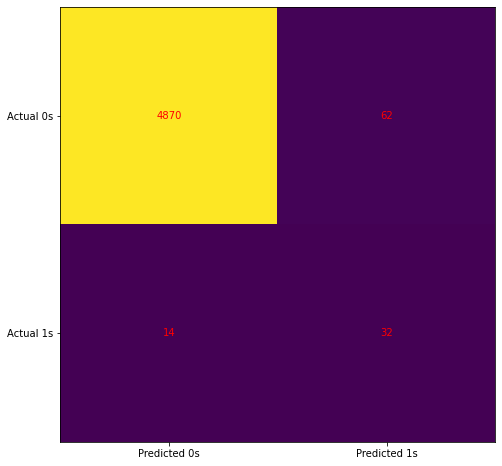

In [15]:
# logistic regression on original data 
LogisticRegression_calc(X, y, 0.3)

X_train_smote.shape (17274, 5408)
y_train_smote.shape (17274,)
smote_count_1, smote_count_0 5758 11516

For SMOTE + RandomUnderSampler with LR from sklearn package:
Logistic classification accurary: 0.9847328244274809
precision_score 0.3170731707317073
recall_score 0.5652173913043478
f1_score 0.40625
roc_auc_score 0.7769314855954017


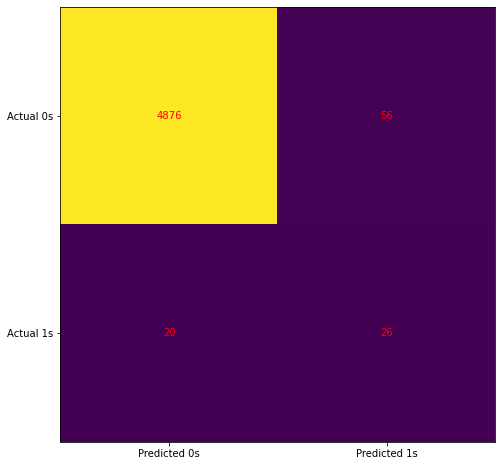

In [16]:
# use sklearn package 
LogisticRegression_package(X, y, 0.3)

X_train_smote.shape (17274, 5408)
y_train_smote.shape (17274,)
smote_count_1, smote_count_0 5758 11516

For SMOTE + RandomUnderSampler with LR from sklearn package:
Logistic classification accurary: 0.9845319405383688
precision_score 0.3037974683544304
recall_score 0.5217391304347826
f1_score 0.384
roc_auc_score 0.755293733911633


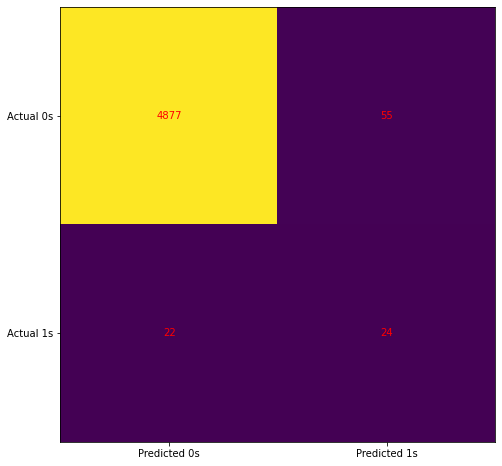

In [17]:
LogisticRegression_package_lasso(X, y, 0.3)
    